<a href="https://colab.research.google.com/github/lisabortiz/Data-Science-Portfolio/blob/main/Project_4/Spotify_Description_for_Students_v01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 4: Music Popularity Prediction


## Problem Definition
>"What's going on?"

This project will take data features collected for songs that have been on the Top 200 Weekly (Global) charts of Spotify in 2020 & 2021. The popularity of the song will be predicted using a tree-based regression model trained on these features.



The goals for the project are:

- Minimize the cross-validated ***root mean squared error ( RMSE )*** when predicting the popularity of a new song.

- Determine the importance of the features in driving the regression result.
The project will be done using tree-based regression techniques as covered in class. The hyperparameters of the trees should be carefully selected to avoid over-fitting.


There are three main challenges for this project:

1. Determining the outcome ( i.e. target ).  There is a "popularity" column.  But other columns may or may not be more appropriate indicators of popularity.

1. Choosing appropriate predictors ( i.e. features ). When building a machine learning model, we want to make sure that we consider how the model will be ultimately used. For this project, we are predicting the popularity of a new song. Therefore, we should only include the predictors we would have for a new song. It might help to imagine that the song will not be released for several weeks.

1. Data cleaning and feature engineering. Some creative cleaning and/or feature engineering may be needed to extract useful information for prediction.



Once again, be sure to go through the whole data science process and document as such in your Jupyter notebook.

The data is available AWS at https://ddc-datascience.s3.amazonaws.com/Projects/Project.4-Spotify/Data/Spotify.csv .



## Data Collection/Sources
>"Initial Setup"

In [ ]:
# import os
# import magic
# import random
# import duckdb
import pandas as pd
from pathlib import Path
import sqlite3 as db
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import sklearn
import numpy as np
from sklearn import datasets, metrics, model_selection
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeRegressor

### Load the data

In [ ]:
url = "https://ddc-datascience.s3.amazonaws.com/Projects/Project.4-Spotify/Data/Spotify.csv"
!curl -s -I {url}

HTTP/1.1 200 OK
x-amz-id-2: agRdNzFli8xHPJYkaW4/nrOcm8M+3CFqv4c+6Q9bVtJYi+uLhO/gvLGd3HerRH90vrntq9XYWpU=
x-amz-request-id: P793B037M5RQCE16
Date: Mon, 03 Nov 2025 04:29:18 GMT
Last-Modified: Wed, 04 Oct 2023 17:23:56 GMT
ETag: "65b9875b11e0d7ea03ee2af024f45e99"
x-amz-server-side-encryption: AES256
Accept-Ranges: bytes
Content-Type: text/csv
Content-Length: 738124
Server: AmazonS3



In [ ]:
!curl -s -O {url}

In [ ]:
ls -la

total 740
drwxr-xr-x 1 root root   4096 Nov  3 03:26 ./
drwxr-xr-x 1 root root   4096 Nov  3 03:21 ../
drwxr-xr-x 4 root root   4096 Oct 30 13:36 .config/
drwxr-xr-x 1 root root   4096 Oct 30 13:36 sample_data/
-rw-r--r-- 1 root root 738124 Nov  3 04:29 Spotify.csv


In [ ]:
!ls

sample_data  Spotify.csv


In [ ]:
!head -1 Spotify.csv | tr , '\n' | cat -n

     1	Index
     2	Highest Charting Position
     3	Number of Times Charted
     4	Week of Highest Charting
     5	Song Name
     6	Streams
     7	Artist
     8	Artist Followers
     9	Song ID
    10	Genre
    11	Release Date
    12	Weeks Charted
    13	Popularity
    14	Danceability
    15	Energy
    16	Loudness
    17	Speechiness
    18	Acousticness
    19	Liveness
    20	Tempo
    21	Duration (ms)
    22	Valence
    23	Chord


In [ ]:
#load data from CSV File
spotify_orig = pd.read_csv("Spotify.csv")
spotify_orig

,Index,Highest Charting Position,Number of Times Charted,Week of Highest Charting,Song Name,Streams,Artist,Artist Followers,Song ID,Genre,...,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord
0,1,1,8,2021-07-23--2021-07-30,Beggin',"48,633,449",Måneskin,3377762,3Wrjm47oTz2sjIgck11l5e,"['indie rock italiano', 'italian pop']",...,0.714,0.8,-4.808,0.0504,0.127,0.359,134.002,211560,0.589,B
1,2,2,3,2021-07-23--2021-07-30,STAY (with Justin Bieber),"47,248,719",The Kid LAROI,2230022,5HCyWlXZPP0y6Gqq8TgA20,['australian hip hop'],...,0.591,0.764,-5.484,0.0483,0.0383,0.103,169.928,141806,0.478,C#/Db
2,3,1,11,2021-06-25--2021-07-02,good 4 u,"40,162,559",Olivia Rodrigo,6266514,4ZtFanR9U6ndgddUvNcjcG,['pop'],...,0.563,0.664,-5.044,0.154,0.335,0.0849,166.928,178147,0.688,A
3,4,3,5,2021-07-02--2021-07-09,Bad Habits,"37,799,456",Ed Sheeran,83293380,6PQ88X9TkUIAUIZJHW2upE,"['pop', 'uk pop']",...,0.808,0.897,-3.712,0.0348,0.0469,0.364,126.026,231041,0.591,B
4,5,5,1,2021-07-23--2021-07-30,INDUSTRY BABY (feat. Jack Harlow),"33,948,454",Lil Nas X,5473565,27NovPIUIRrOZoCHxABJwK,"['lgbtq+ hip hop', 'pop rap']",...,0.736,0.704,-7.409,0.0615,0.0203,0.0501,149.995,212000,0.894,D#/Eb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1551,1552,195,1,2019-12-27--2020-01-03,New Rules,"4,630,675",Dua Lipa,27167675,2ekn2ttSfGqwhhate0LSR0,"['dance pop', 'pop', 'uk pop']",...,0.762,0.7,-6.021,0.0694,0.00261,0.153,116.073,209320,0.608,A
1552,1553,196,1,2019-12-27--2020-01-03,Cheirosa - Ao Vivo,"4,623,030",Jorge & Mateus,15019109,2PWjKmjyTZeDpmOUa3a5da,"['sertanejo', 'sertanejo universitario']",...,0.528,0.87,-3.123,0.0851,0.24,0.333,152.37,181930,0.714,B
1553,1554,197,1,2019-12-27--2020-01-03,Havana (feat. Young Thug),"4,620,876",Camila Cabello,22698747,1rfofaqEpACxVEHIZBJe6W,"['dance pop', 'electropop', 'pop', 'post-teen ...",...,0.765,0.523,-4.333,0.03,0.184,0.132,104.988,217307,0.394,D
1554,1555,198,1,2019-12-27--2020-01-03,Surtada - Remix Brega Funk,"4,607,385","Dadá Boladão, Tati Zaqui, OIK",208630,5F8ffc8KWKNawllr5WsW0r,"['brega funk', 'funk carioca']",...,0.832,0.55,-7.026,0.0587,0.249,0.182,154.064,152784,0.881,F


In [ ]:
spotify_orig.isnull().sum().sum()

np.int64(0)

In [ ]:
spotify_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1556 entries, 0 to 1555
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Index                      1556 non-null   int64 
 1   Highest Charting Position  1556 non-null   int64 
 2   Number of Times Charted    1556 non-null   int64 
 3   Week of Highest Charting   1556 non-null   object
 4   Song Name                  1556 non-null   object
 5   Streams                    1556 non-null   object
 6   Artist                     1556 non-null   object
 7   Artist Followers           1556 non-null   object
 8   Song ID                    1556 non-null   object
 9   Genre                      1556 non-null   object
 10  Release Date               1556 non-null   object
 11  Weeks Charted              1556 non-null   object
 12  Popularity                 1556 non-null   object
 13  Danceability               1556 non-null   object
 14  Energy  

### Create a copy

In [ ]:
spotify = spotify_orig.copy()

###Inspection
Now that the libraries are imported and the data set is loaded, we can verify it's import and perform an initial inspection of the data.

In the inital check, we look at a few details:


*   Head (first 5 rows)
*   Tail (Last 5 rows)
*   Info (File size, data types, rows, colums)
*   Shape (Row and Column Count)
*   Size (individual elements)

This gives a quick glance at what kind of forseeable challenges with the current data set.


In [ ]:
spotify.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1556 entries, 0 to 1555
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Index                      1556 non-null   int64 
 1   Highest Charting Position  1556 non-null   int64 
 2   Number of Times Charted    1556 non-null   int64 
 3   Week of Highest Charting   1556 non-null   object
 4   Song Name                  1556 non-null   object
 5   Streams                    1556 non-null   object
 6   Artist                     1556 non-null   object
 7   Artist Followers           1556 non-null   object
 8   Song ID                    1556 non-null   object
 9   Genre                      1556 non-null   object
 10  Release Date               1556 non-null   object
 11  Weeks Charted              1556 non-null   object
 12  Popularity                 1556 non-null   object
 13  Danceability               1556 non-null   object
 14  Energy  

In [ ]:
spotify.shape


(1556, 23)

In [ ]:
spotify.size

35788

In [ ]:
spotify.head()

,Index,Highest Charting Position,Number of Times Charted,Week of Highest Charting,Song Name,Streams,Artist,Artist Followers,Song ID,Genre,...,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord
0,1,1,8,2021-07-23--2021-07-30,Beggin',"48,633,449",Måneskin,3377762,3Wrjm47oTz2sjIgck11l5e,"['indie rock italiano', 'italian pop']",...,0.714,0.8,-4.808,0.0504,0.127,0.359,134.002,211560,0.589,B
1,2,2,3,2021-07-23--2021-07-30,STAY (with Justin Bieber),"47,248,719",The Kid LAROI,2230022,5HCyWlXZPP0y6Gqq8TgA20,['australian hip hop'],...,0.591,0.764,-5.484,0.0483,0.0383,0.103,169.928,141806,0.478,C#/Db
2,3,1,11,2021-06-25--2021-07-02,good 4 u,"40,162,559",Olivia Rodrigo,6266514,4ZtFanR9U6ndgddUvNcjcG,['pop'],...,0.563,0.664,-5.044,0.154,0.335,0.0849,166.928,178147,0.688,A
3,4,3,5,2021-07-02--2021-07-09,Bad Habits,"37,799,456",Ed Sheeran,83293380,6PQ88X9TkUIAUIZJHW2upE,"['pop', 'uk pop']",...,0.808,0.897,-3.712,0.0348,0.0469,0.364,126.026,231041,0.591,B
4,5,5,1,2021-07-23--2021-07-30,INDUSTRY BABY (feat. Jack Harlow),"33,948,454",Lil Nas X,5473565,27NovPIUIRrOZoCHxABJwK,"['lgbtq+ hip hop', 'pop rap']",...,0.736,0.704,-7.409,0.0615,0.0203,0.0501,149.995,212000,0.894,D#/Eb


In [ ]:
spotify.tail()

,Index,Highest Charting Position,Number of Times Charted,Week of Highest Charting,Song Name,Streams,Artist,Artist Followers,Song ID,Genre,...,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord
1551,1552,195,1,2019-12-27--2020-01-03,New Rules,"4,630,675",Dua Lipa,27167675,2ekn2ttSfGqwhhate0LSR0,"['dance pop', 'pop', 'uk pop']",...,0.762,0.7,-6.021,0.0694,0.00261,0.153,116.073,209320,0.608,A
1552,1553,196,1,2019-12-27--2020-01-03,Cheirosa - Ao Vivo,"4,623,030",Jorge & Mateus,15019109,2PWjKmjyTZeDpmOUa3a5da,"['sertanejo', 'sertanejo universitario']",...,0.528,0.87,-3.123,0.0851,0.24,0.333,152.37,181930,0.714,B
1553,1554,197,1,2019-12-27--2020-01-03,Havana (feat. Young Thug),"4,620,876",Camila Cabello,22698747,1rfofaqEpACxVEHIZBJe6W,"['dance pop', 'electropop', 'pop', 'post-teen ...",...,0.765,0.523,-4.333,0.03,0.184,0.132,104.988,217307,0.394,D
1554,1555,198,1,2019-12-27--2020-01-03,Surtada - Remix Brega Funk,"4,607,385","Dadá Boladão, Tati Zaqui, OIK",208630,5F8ffc8KWKNawllr5WsW0r,"['brega funk', 'funk carioca']",...,0.832,0.55,-7.026,0.0587,0.249,0.182,154.064,152784,0.881,F
1555,1556,199,1,2019-12-27--2020-01-03,Lover (Remix) [feat. Shawn Mendes],"4,595,450",Taylor Swift,42227614,3i9UVldZOE0aD0JnyfAZZ0,"['pop', 'post-teen pop']",...,0.448,0.603,-7.176,0.064,0.433,0.0862,205.272,221307,0.422,G


### Check Data For Use

Some of the important details to check regarding data set are the following:


*   Total Number of Null Values
*   Total Number of Unique Values
*   Target and its contents
*   Null Values in Target Column
*   Percentage of Null Values compared to the Whole Column
*   Sums

This gives some insight to the direction we should take to start cleaning data.  

There is a significant amount of null values in Target, Columns and Rows.  


In [ ]:
spotify.isnull().sum().sum()

np.int64(0)

In [ ]:
spotify.describe(include ="all").transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Index,1556.0,NaN,NaN,NaN,778.5,449.322824,1.0,389.75,778.5,1167.25,1556.0
Highest Charting Position,1556.0,NaN,NaN,NaN,87.744216,58.147225,1.0,37.0,80.0,137.0,200.0
Number of Times Charted,1556.0,NaN,NaN,NaN,10.66838,16.360546,1.0,1.0,4.0,12.0,142.0
Week of Highest Charting,1556,83,2019-12-27--2020-01-03,89,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Song Name,1556,1556,Lover (Remix) [feat. Shawn Mendes],1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Streams,1556,1556,"4,595,450",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Artist,1556,716,Taylor Swift,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Artist Followers,1556,600,42227614,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Song ID,1556,1517,,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Genre,1556,395,[],75,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
spotify['Highest Charting Position'].describe(include ="all").transpose()

,Highest Charting Position
count,1556.000000
mean,87.744216
std,58.147225
min,1.000000
25%,37.000000
50%,80.000000
75%,137.000000
max,200.000000


In [ ]:
spotify.sort_values(by='Highest Charting Position', axis=0)['Popularity']


,Popularity
0,100
39,86
46,89
79,83
91,86
...,...
198,77
390,72
1168,62
504,66


In [ ]:
spotify['Highest Charting Position'].isnull().sum()

np.int64(0)

## Data Cleaning

>  "Clean Up Data"

In [ ]:
#There were several rows that had values of blank spaces.  This is converting into NaN
spotify = spotify.replace(' ', np.nan)

In [ ]:
#Remove any row with nulls.  There were 11 found.
spotify.dropna(axis=0, how='any', inplace=True)
spotify.isnull().sum()

,0
Index,0
Highest Charting Position,0
Number of Times Charted,0
Week of Highest Charting,0
Song Name,0
Streams,0
Artist,0
Artist Followers,0
Song ID,0
Genre,0


In [ ]:
#Streams column has commas in data value, and this removes the commas in place.
spotify['Streams'] = spotify['Streams'].astype(str).str.replace(',', '', regex=False)

In [ ]:
spotify.columns

Index(['Index', 'Highest Charting Position', 'Number of Times Charted',
       'Week of Highest Charting', 'Song Name', 'Streams', 'Artist',
       'Artist Followers', 'Song ID', 'Genre', 'Release Date', 'Weeks Charted',
       'Popularity', 'Danceability', 'Energy', 'Loudness', 'Speechiness',
       'Acousticness', 'Liveness', 'Tempo', 'Duration (ms)', 'Valence',
       'Chord'],
      dtype='object')

In [ ]:
# Select the columns we identified as "Unique Identifiers" and Columns too similar to our target in our inspection by assigning
# it to a list, ("bye"), that we want to remove.
bye = ['Index', 'Number of Times Charted', 'Release Date', 'Week of Highest Charting', 'Weeks Charted', 'Artist', 'Song Name', 'Song ID', 'Genre', 'Chord']

In [ ]:
spot_drop = spotify[bye].copy()

In [ ]:
spot_drop.shape

(1545, 10)

In [ ]:
spotify.drop(columns=bye, inplace=True)

In [ ]:
#The columns are still object type.  This is trying to convert into numbers.
cols_to_convert = spotify.columns

In [ ]:
cols_to_convert.drop('Highest Charting Position')

Index(['Streams', 'Artist Followers', 'Popularity', 'Danceability', 'Energy',
       'Loudness', 'Speechiness', 'Acousticness', 'Liveness', 'Tempo',
       'Duration (ms)', 'Valence'],
      dtype='object')

In [ ]:
for col in cols_to_convert:
    spotify[col] = pd.to_numeric(spotify[col], errors='coerce')

In [ ]:
spotify.duplicated().sum()

np.int64(0)

In [ ]:
spotify.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1545 entries, 0 to 1555
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Highest Charting Position  1545 non-null   int64  
 1   Streams                    1545 non-null   int64  
 2   Artist Followers           1545 non-null   int64  
 3   Popularity                 1545 non-null   int64  
 4   Danceability               1545 non-null   float64
 5   Energy                     1545 non-null   float64
 6   Loudness                   1545 non-null   float64
 7   Speechiness                1545 non-null   float64
 8   Acousticness               1545 non-null   float64
 9   Liveness                   1545 non-null   float64
 10  Tempo                      1545 non-null   float64
 11  Duration (ms)              1545 non-null   int64  
 12  Valence                    1545 non-null   float64
dtypes: float64(8), int64(5)
memory usage: 169.0 KB


## Exploratory Data Analysis
> "Look Around"

After Cleaning the Data set, we can explore the data for:
*  Patterns and Relations of data variables
*  Outliers
*  Obvious Errors

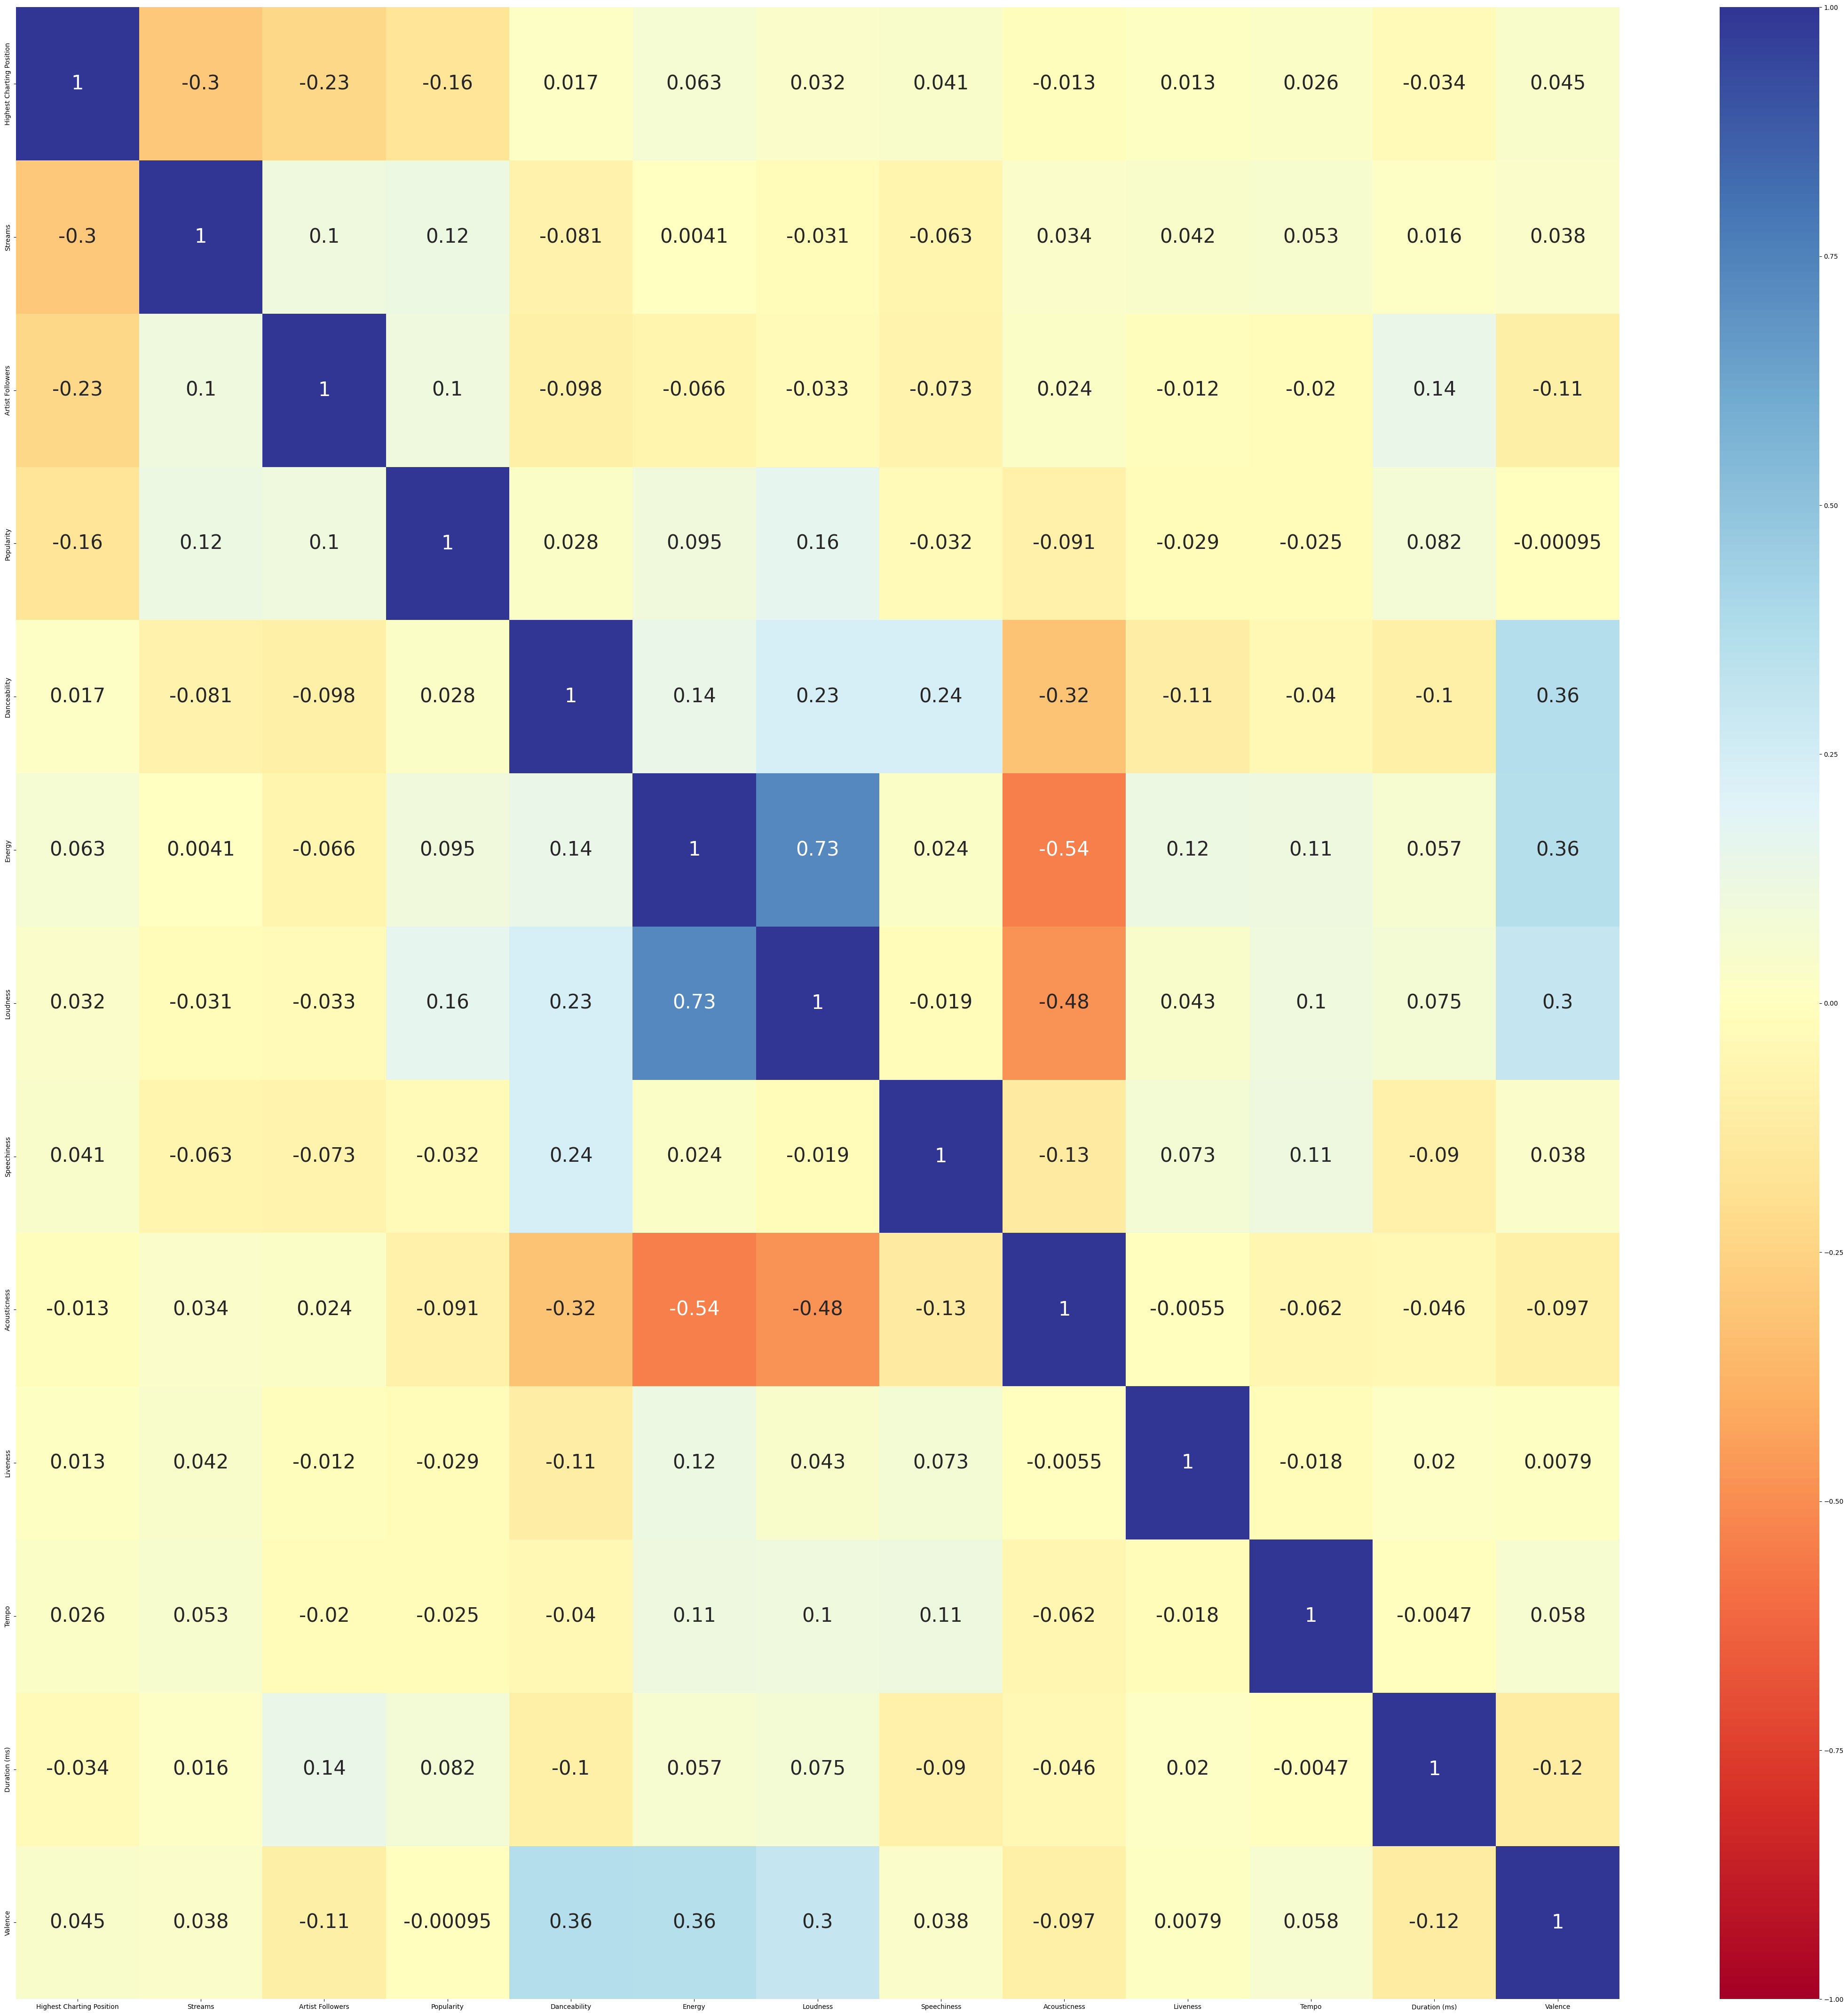

In [ ]:
#Correlation plot shows relationship between "target" and other variables.

corr = spotify.select_dtypes(include='number').corr()
plt.figure(figsize=(55,55))
sns.heatmap(corr, cmap='RdYlBu', annot=True, vmin = -1, vmax = 1, annot_kws={"fontsize": 30});

array([[<Axes: title={'center': 'Highest Charting Position'}>,
        <Axes: title={'center': 'Streams'}>,
        <Axes: title={'center': 'Artist Followers'}>,
        <Axes: title={'center': 'Popularity'}>],
       [<Axes: title={'center': 'Danceability'}>,
        <Axes: title={'center': 'Energy'}>,
        <Axes: title={'center': 'Loudness'}>,
        <Axes: title={'center': 'Speechiness'}>],
       [<Axes: title={'center': 'Acousticness'}>,
        <Axes: title={'center': 'Liveness'}>,
        <Axes: title={'center': 'Tempo'}>,
        <Axes: title={'center': 'Duration (ms)'}>],
       [<Axes: title={'center': 'Valence'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

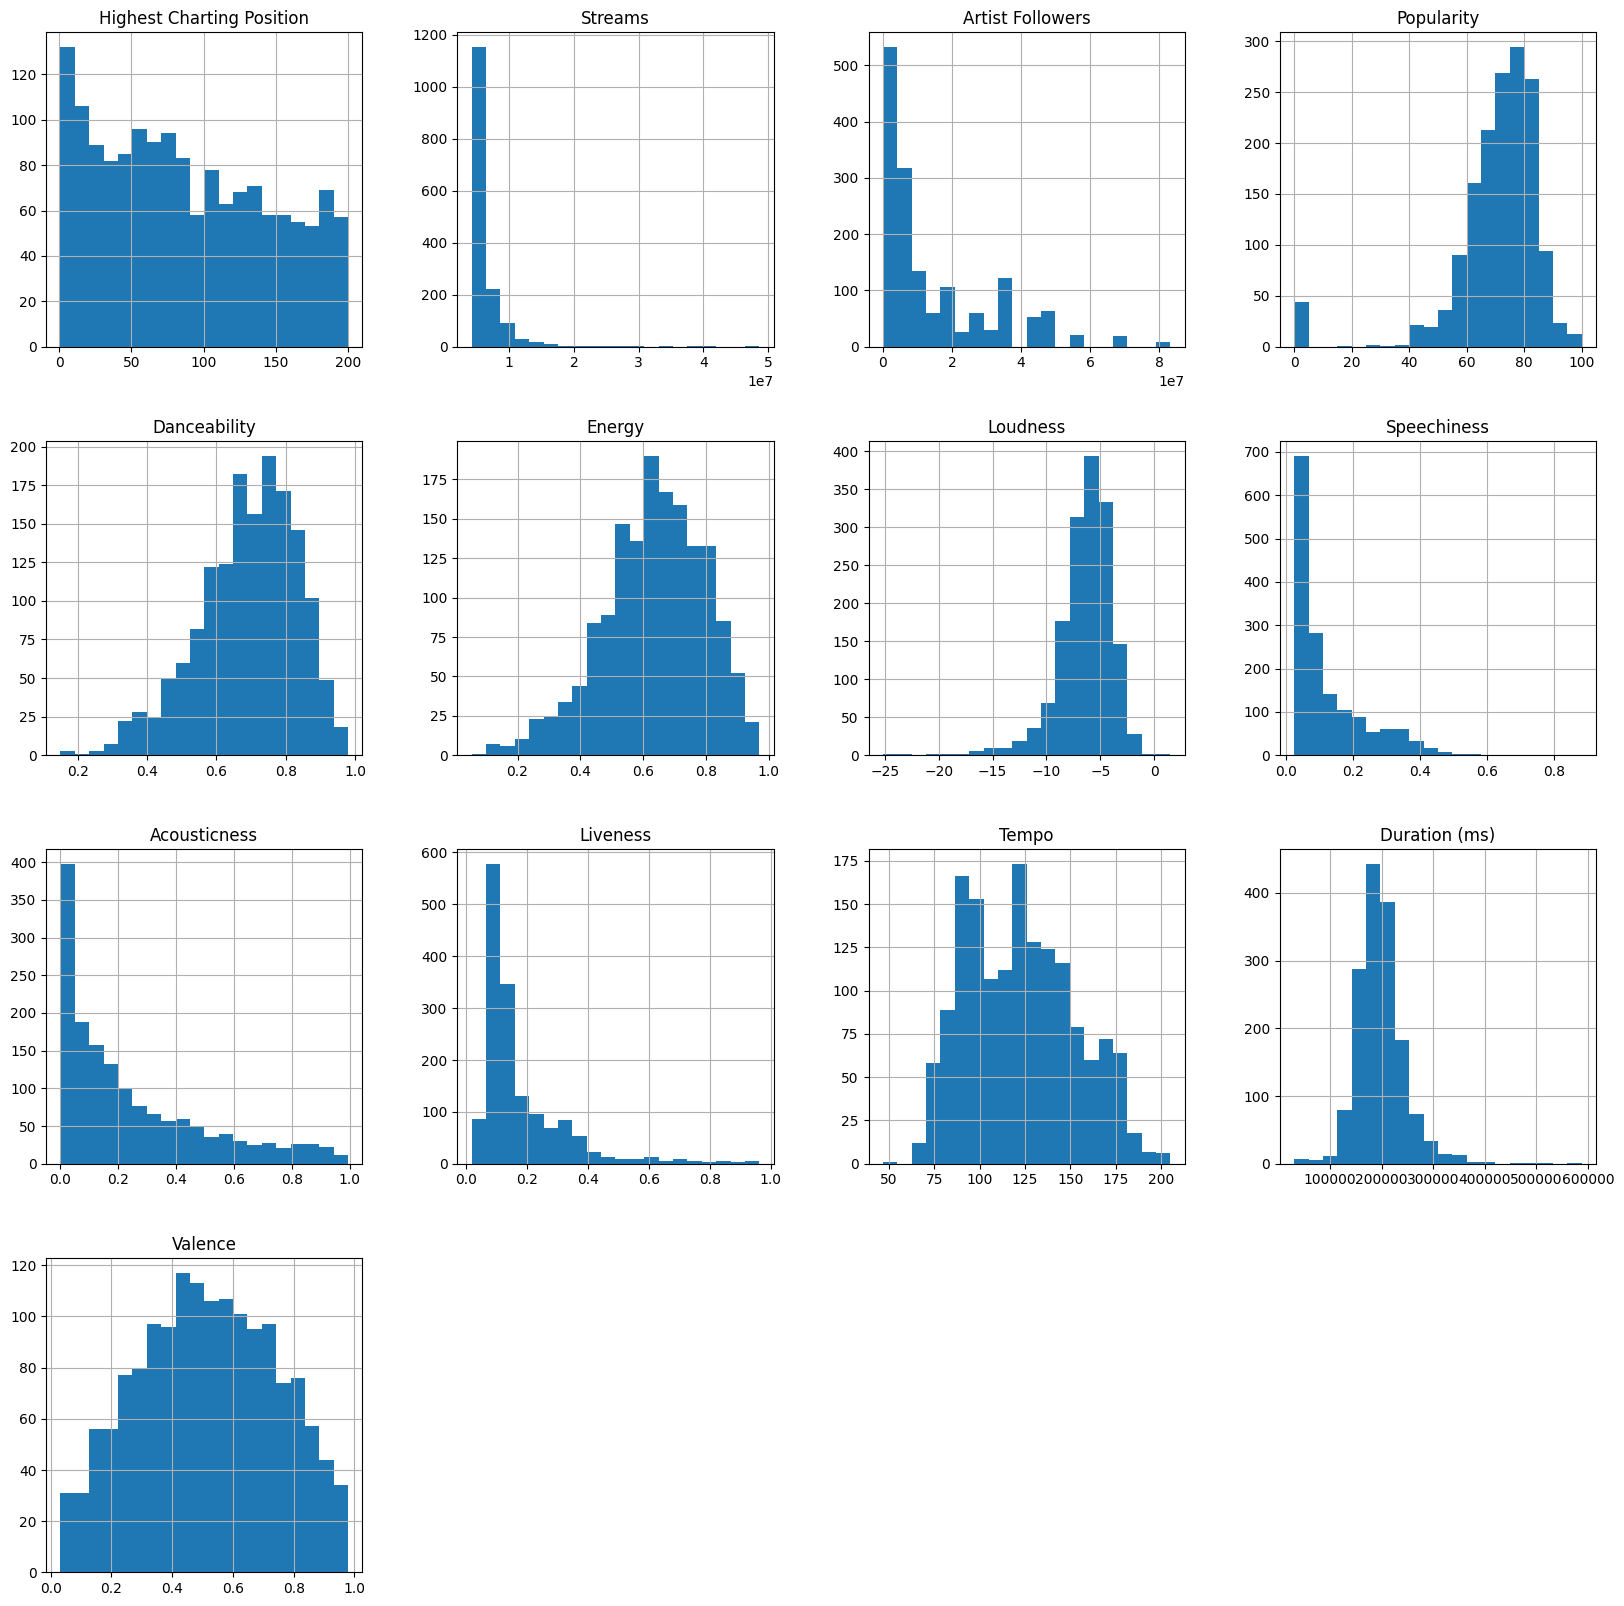

In [ ]:
# Histogram Grid shows distribution of the data across the data set variables.
spotify.hist(figsize=(20,20), bins=20)

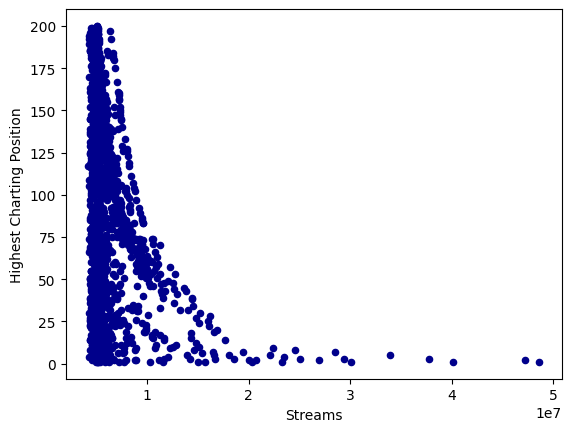

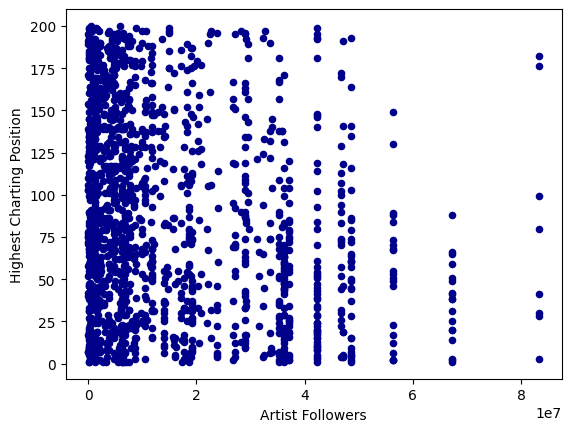

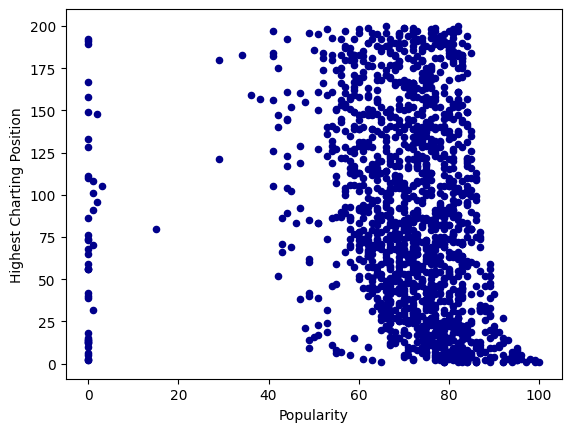

In [ ]:
# Filter values more than Absoulte value of 0.1
filter = np.abs(corr['Highest Charting Position']) > .1
corr[filter]
selected_columns=corr[filter].index
selected_columns

# Plotting the Variables compared to the 'Highest Charting Position' prior to calcuations (the range excludes SalePrice)
for variable in selected_columns[1:14]:
  spotify.plot.scatter(x=variable,
                        y='Highest Charting Position',
                        c='DarkBlue')
plt.show()

##Data Processing
>  "Crunch Numbers"

In [ ]:
y = spotify['Highest Charting Position']
X = spotify[selected_columns].copy()
X.drop('Highest Charting Position', axis=1, inplace=True)

In [ ]:
spotify[selected_columns].isna().sum()

,0
Highest Charting Position,0
Streams,0
Artist Followers,0
Popularity,0


In [ ]:
X.columns

Index(['Streams', 'Artist Followers', 'Popularity'], dtype='object')

In [ ]:
#Scale the data off of Sales, and split the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=5)

#Scaling, normalize the features
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
np.isnan(X).sum()

,0
Streams,0
Artist Followers,0
Popularity,0


In [ ]:
# Fit a linear model using Sklearn
model = LinearRegression()
my_fit_lr = model.fit(X_train, y_train)

In [ ]:
# Create a data frame with the results from the linear regression models
model_results = pd.DataFrame()
model_results['Predictor'] = X.columns
model_results['Linear'] = my_fit_lr.coef_
model_results.sort_values(by=['Linear'],inplace=True, ascending=False)
model_results

,Predictor,Linear
2,Popularity,-6.036898
1,Artist Followers,-11.735541
0,Streams,-14.383419


## Data Visualization
> "Lets Plot"

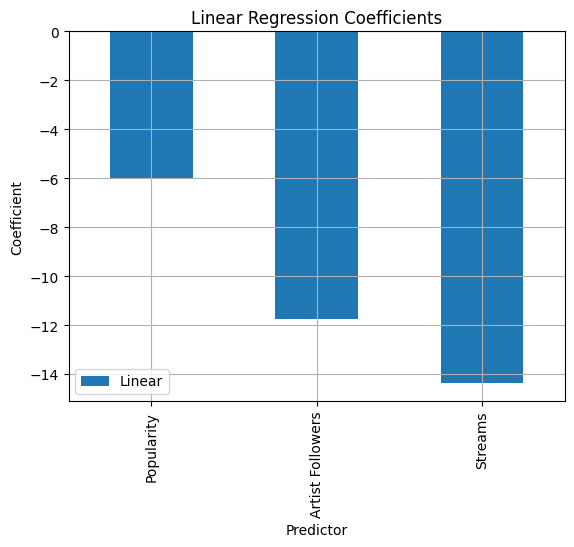

In [ ]:
# Plot the coefficients
model_results.plot(x = 'Predictor', y = 'Linear', kind = 'bar', ylabel='Coefficient', title='Linear Regression Coefficients')
plt.grid()

In [ ]:
# Perform CV
n = 500
results = np.zeros(n)
for idx in range(n):
  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)
  model = LinearRegression()
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  results[idx] = np.sqrt(mean_squared_error(y_test,y_pred))
print(f"CV RMSE: {results.mean().round(2)}")
print(f"Number of Predictors: {len(X.columns)}")

CV RMSE: 53.97
Number of Predictors: 3


In [ ]:
# Specify values of alpha we want to try
alph = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1e-1, 1, 2, 3, 4, 5, 10, 20, 30, 50]

# Create empty list to hold results
results_alpha = []

for i in alph:
  # Train the model
  my_fit_rr = Ridge(alpha = i) # Looping through alpha

  scalar = StandardScaler()

  pipeline = Pipeline([('transformer', scalar), ('estimator', my_fit_rr)])

  # Calculate CV RMSE
  results = cross_val_score(
      pipeline,
      X,
      y,
      scoring='neg_root_mean_squared_error',
      cv = 10
      )
  rmse = abs(results.mean())
  results_alpha.append(rmse)

results_df = pd.DataFrame({'Alpha': alph, 'RMSE': results_alpha})
print(results_df.sort_values(by=['RMSE']))

           Alpha       RMSE
15  5.000000e+01  54.236293
14  3.000000e+01  54.244489
13  2.000000e+01  54.249267
12  1.000000e+01  54.254520
11  5.000000e+00  54.257329
10  4.000000e+00  54.257905
9   3.000000e+00  54.258487
8   2.000000e+00  54.259074
7   1.000000e+00  54.259665
6   1.000000e-01  54.260202
5   1.000000e-02  54.260256
4   1.000000e-03  54.260262
3   1.000000e-04  54.260262
2   1.000000e-08  54.260262
1   1.000000e-10  54.260262
0   1.000000e-15  54.260262


In [ ]:
#Trying Min - Max Scaler vs Standard Scaler
# Specify values of alpha we want to try
alph = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1e-1, 1, 2, 3, 4, 5, 10, 20, 30, 50]

# Create empty list to hold results
results_alpha = []

for i in alph:
  # Train the model
  my_fit_rr = Ridge(alpha = i) # Looping through alpha

  scalar = MinMaxScaler()

  pipeline = Pipeline([('transformer', scalar), ('estimator', my_fit_rr)])

  # Calculate CV RMSE
  results = cross_val_score(
      pipeline,
      X,
      y,
      scoring='neg_root_mean_squared_error',
      cv = 10
      )
  rmse = abs(results.mean())
  results_alpha.append(rmse)

results_df = pd.DataFrame({'Alpha': alph, 'RMSE': results_alpha})
print(results_df.sort_values(by=['RMSE']))

           Alpha       RMSE
7   1.000000e+00  54.218004
8   2.000000e+00  54.237402
6   1.000000e-01  54.252039
5   1.000000e-02  54.259392
4   1.000000e-03  54.260175
3   1.000000e-04  54.260254
2   1.000000e-08  54.260262
1   1.000000e-10  54.260262
0   1.000000e-15  54.260262
9   3.000000e+00  54.289891
10  4.000000e+00  54.359457
11  5.000000e+00  54.437015
12  1.000000e+01  54.824826
13  2.000000e+01  55.394752
14  3.000000e+01  55.774098
15  5.000000e+01  56.273113


In [ ]:
# %%capture --no-stdout
X_lasso = X
y_lasso = y

# Specify values of alpha we want to try
alph = [50, 75, 100, 200, 300, ]

# Create empty list to hold results
results_alpha = []

for i in alph:
  # Calculate CV RMSE
  n = 200
  results = np.zeros(n)

  for idx in range(n):
    # Create the model
    my_fit_lasso = Lasso(alpha = i, tol = .01, max_iter=10_000); # Looping through alpha

    # Train, test split
    X_train, X_test, y_train, y_test = train_test_split(X_lasso, y_lasso, test_size=0.25)

    # Standard scale only training features
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)

    # Scale testing features
    X_test = scaler.transform(X_test)

    # Fit regression
    my_fit_lasso.fit(X_train, y_train)

    # Predict
    y_predl = my_fit_lasso.predict(X_test)

    # Calculate and record performance metric
    results[idx] = np.sqrt(mean_squared_error(y_test,y_predl))

  results_alpha.append(results.mean())

results_df = pd.DataFrame({'Alpha': alph, 'RMSE': results_alpha})


(-4.0, 4.0)

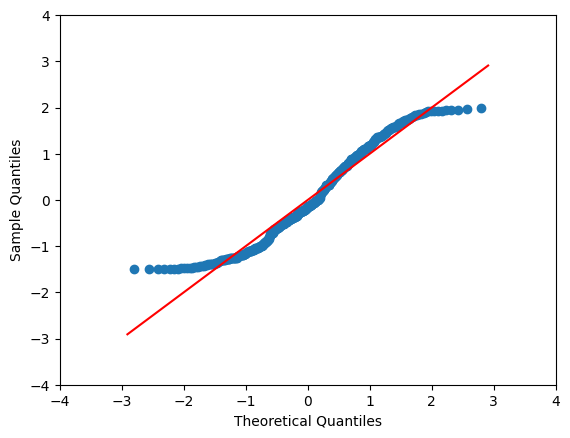

In [ ]:
# QQ Plot of Decision Tree - Residuals are normally distributed
res = y_test - y_predl
sm.qqplot(res, fit=True, line="45") ;
plt.xlim(-4, 4)
plt.ylim(-4, 4)

In [ ]:
results_df

,Alpha,RMSE
0,50,58.129209
1,75,58.414146
2,100,58.137025
3,200,58.117174
4,300,58.102587


In [ ]:
numLoops = 500

rms_error = np.zeros(numLoops)

for idx in range(0,numLoops):
  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
  model = DecisionTreeRegressor(max_depth=3)         # Arbitrarily choosing max_depth of 3
  model.fit(X_train,y_train)
  y_predt = model.predict(X_test)
  rms_error[idx] = np.sqrt(mean_squared_error(y_test, y_predt))

print(f"CV RMSE: {rms_error.mean().round(2)}")

CV RMSE: 52.11


(-4.0, 4.0)

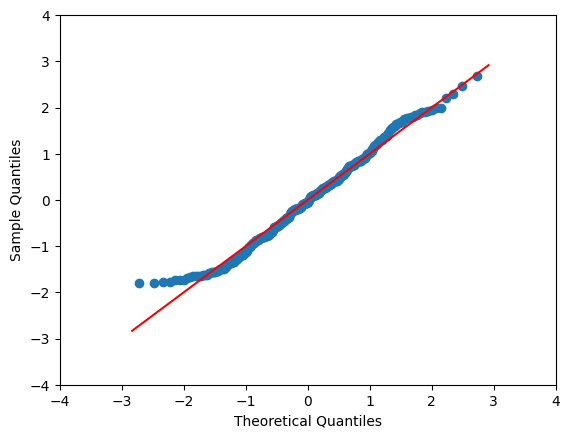

In [ ]:
# QQ Plot of Decision Tree - Residuals are normally distributed
res = y_test - y_predt
sm.qqplot(res, fit=True, line="45") ;
plt.xlim(-4, 4)
plt.ylim(-4, 4)

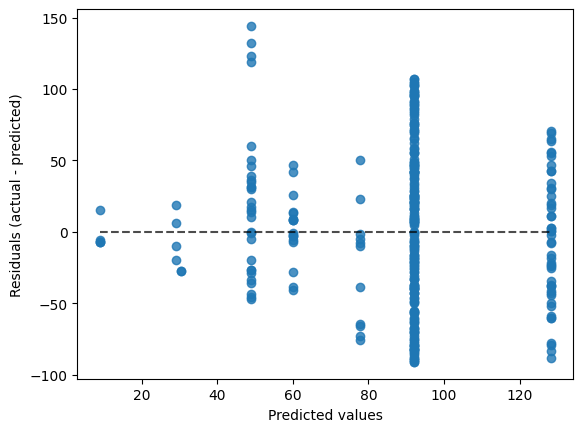

In [ ]:
display=sklearn.metrics.PredictionErrorDisplay(y_true=y_test, y_pred=y_predt)
display.plot()
plt.show()

In [ ]:
np.unique(y)

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

## Communication of Results
> "What did we find?"

Using **'Highest Charting Position'** as target, and filtering features with a correlation of 0.1, the features were limited to the following:
* Streams
* Artist Followers
* Popularity

Linear Regression provided CV RMSE: 53.97

Ridge Regression provided RMSE: 54.22

Lasso Regression RMSE: 58.10

Decision Tree CV RMSE: 51.96